# Analysis for NFL Teams Current Success Based on Essential Positions Historical Statistics

Josh McCoy and Zach Goodman

[Link to website](https://joshmccoy2.github.io)

# Project Goals

The goal of our project is to analyze significant positions of NFL teams and see which statistics for those positions correlate to success. We will determine which positions in the NFL are important by utilizing salary cap data for each NFL team between 2014-2020. After we have idenitifed the most significant positions for NFL teams, we will create a predictive model that examines the statistics for that given position and will predict the total wins an NFL franchise should have in that given season.


### Importing all libraries and reading in all CSVs

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot
import requests
from bs4 import BeautifulSoup

stadiums_df = pd.read_csv("stadiums.csv", encoding="ISO-8859-1") #import Stadium info
teams_df = pd.read_csv("nfl_teams.csv", encoding="ISO-8859-1")  #import Team info
scores_df = pd.read_csv("spreadspoke_scores.csv", encoding="ISO-8859-1") #import each game score/spread info
salary_cap = pd.read_csv("2014-thru-2020-cap-tables-1.csv", encoding="ISO-8859-1")

# ETL________________________________________________________

## NFL Teams and Scores Dataset

We obtained this data from the "NFL Scores and Betting Data" dataset found on Kaggle.com. It contains NFL game results since 1966, and information about the betting odds of each game since 1979, along with information about the weather from each game. The betting odds include the favored team, the over/under of each game and where the game was played. It also contains information about each stadium and team that has ever existed in the NFL.

#### Table 1:

This first table comes from "stadiums.csv", found in the "NFL Scores and Betting Data" dataset. It contains information about all of the stadiums that NFL games have been played in and ample information about each of them. For example, it has the stadium location, both in terms of city and coordinates, the opening and/or closing year of the arena, stadium type, weather type, capacity, and more. This dataframe can be useful in many different ways. Some questions we can answer by examining this dataframe is, which is the best stadium to play a football game in hot weather, or snowy weather? Does stadium capacity affect the outcome of games? Does the elevation, like in Denver, negatively affect the visiting team that isn't used to those conditions? 

In [69]:
stadiums_df.head(3)

,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
0,Acrisure Stadium,"Pittsburgh, PA",2001.0,NaN,outdoor,"100 Art Rooney Ave, Pittsburgh, PA 15212",15212,cold,"65,500",Grass,USW00094823,"PITTSBURGH ASOS, PA US",40.4846,-80.2144,366.7
1,Alamo Dome,"San Antonio, TX",NaN,NaN,indoor,"100 Montana St, San Antonio, TX 78203",78203,dome,72000,FieldTurf,NaN,NaN,NaN,NaN,NaN
2,Allegiant Stadium,"Paradise, NV",2020.0,NaN,indoor,NaN,NaN,dome,65000,Grass,NaN,NaN,NaN,NaN,NaN


Lets check the dtypes.

In [70]:
stadiums_df.dtypes

stadium_name                     object
stadium_location                 object
stadium_open                    float64
stadium_close                   float64
stadium_type                     object
stadium_address                  object
stadium_weather_station_code     object
stadium_weather_type             object
stadium_capacity                 object
stadium_surface                  object
STATION                          object
NAME                             object
LATITUDE                        float64
LONGITUDE                       float64
ELEVATION                       float64
dtype: object

checking the dtypes we see that they are properly formatted.

##### Table 2:

This table comes from "nfl_teams.csv", also found in the "NFL Scores and Betting Data" dataset. It contains information about every team that is currently in the league, or has ever been in the NFL. As you can see, it contains the full and short team names, team IDs, and the teams' conference and division, both before and after 2002.

In [71]:
teams_df.head(3)

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
0,Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West,NFC,NFC West
1,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West
2,Baltimore Colts,Colts,IND,CLT,AFC,NaN,AFC,AFC East


#### Table 3:

This table comes from "spreadspoke_scores.csv", also found in NFL Scores and Betting Data" dataset. It contains information about the scores of each game since the inception of the NFL. Since we only care about modern football, we will limit it to 2014. This data will help us answer questions like "Which team has had the most success since 2014?" "Which teams have the best/worst record each year?". We will be combining this data with other datasets like salary cap information and position statistics to get a better understanding on what makes NFL teams successful.

In [72]:
scores_df.head(3)

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14.0,23.0,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71.0,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45.0,7.0,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70.0,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27.0,7.0,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82.0,NaN


Now, we are separating regular season games from playoff games. Our intended use of this data is to predict regular season wins. 

In [73]:
scores_df = scores_df[scores_df["schedule_season"]>=2014]  #limiting the dataFrame to dates 2014 and later
scores_df = scores_df[scores_df["schedule_playoff"]==False]
df_scores = pd.read_csv("spreadspoke_scores.csv", encoding="ISO-8859-1") #import each game score/spread info
playoffs = df_scores[df_scores["schedule_season"]>=2014]  #limiting the dataFrame to dates 2014 and later
playoffs = playoffs[playoffs["schedule_playoff"]==True]
scores_df.head(3)


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
11076,9/4/2014,2014,1,False,Seattle Seahawks,36.0,16.0,Green Bay Packers,SEA,-4.5,46.5,CenturyLink Field,False,70.0,5.0,NaN,NaN
11077,9/7/2014,2014,1,False,Atlanta Falcons,37.0,34.0,New Orleans Saints,NO,-3.0,52,Georgia Dome,False,72.0,0.0,NaN,DOME
11078,9/7/2014,2014,1,False,Baltimore Ravens,16.0,23.0,Cincinnati Bengals,BAL,-1.0,42.5,M&T Bank Stadium,False,78.0,0.0,NaN,NaN


Now, we create a column to add in away and home wins, as well as away and home losses.

In [74]:
scores_df['away_win'] = np.where(scores_df['score_home'] < scores_df['score_away'], 1, 0)
scores_df['away_loss'] = np.where(scores_df['score_home'] > scores_df['score_away'], 1, 0)
scores_df['home_win'] = np.where(scores_df['score_home'] > scores_df['score_away'], 1, 0)
scores_df['home_loss'] = np.where(scores_df['score_home'] < scores_df['score_away'], 1, 0)
scores_df.head(3)

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,away_win,away_loss,home_win,home_loss
11076,9/4/2014,2014,1,False,Seattle Seahawks,36.0,16.0,Green Bay Packers,SEA,-4.5,...,CenturyLink Field,False,70.0,5.0,NaN,NaN,0,1,1,0
11077,9/7/2014,2014,1,False,Atlanta Falcons,37.0,34.0,New Orleans Saints,NO,-3.0,...,Georgia Dome,False,72.0,0.0,NaN,DOME,0,1,1,0
11078,9/7/2014,2014,1,False,Baltimore Ravens,16.0,23.0,Cincinnati Bengals,BAL,-1.0,...,M&T Bank Stadium,False,78.0,0.0,NaN,NaN,1,0,0,1


Now, we want to sum all these wins and losses to create a table to see the total success of these teams.

In [75]:
record = pd.DataFrame()
record["home_win"] = scores_df.groupby("team_home")[["home_win"]].sum() 
record["home_loss"] = scores_df.groupby("team_home")[["home_loss"]].sum() 
record["away_win"] = scores_df.groupby("team_away")[["away_win"]].sum()
record["away_loss"] = scores_df.groupby("team_away")[["away_loss"]].sum()
record["total_win"] = record["home_win"] + record["away_win"] 
record["total_loss"] = record["home_loss"] + record["away_loss"]
record = record.reset_index()
record = record.rename(columns={'team_home': 'team_name'})
record.head(3)

,team_name,home_win,home_loss,away_win,away_loss,total_win,total_loss
0,Arizona Cardinals,32,33,36,31,68,64
1,Atlanta Falcons,29,37,33,35,62,72
2,Baltimore Ravens,44,24,34,32,78,56


Finally, we will add this table (record) to our original team table (team_name).

In [76]:
teams_df = teams_df.merge(record, on=["team_name"], how='inner', suffixes=(False, False))
teams_df = teams_df.set_index("team_name")
teams_df.head(3)

,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002,home_win,home_loss,away_win,away_loss,total_win,total_loss
team_name,,,,,,,,,,,,,
Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West,NFC,NFC West,32,33,36,31,68,64
Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West,29,37,33,35,62,72
Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North,AFC,AFC Central,44,24,34,32,78,56


Now, we will check the dtype. 

In [77]:
teams_df.dtypes

team_name_short            object
team_id                    object
team_id_pfr                object
team_conference            object
team_division              object
team_conference_pre2002    object
team_division_pre2002      object
home_win                    int64
home_loss                   int64
away_win                    int64
away_loss                   int64
total_win                   int64
total_loss                  int64
dtype: object

#### Table 4:

salary_cap was found in the NFL Salaries dataset on Kaggle.com and identifies the cap space information for each team like player name, position, cap hit, cap percentage, season, and team. Salary Cap limits NFL franchises in the amount of money they spend on their respective players. This is important because we want to analyze if there is a difference in the positions taking up the most cap percentage for unsuccessful teams versus successful teams.

In [78]:
salary_cap = salary_cap.sort_values(by=["team", "season", "pos"], ascending=True)
salary_cap = salary_cap.rename(columns={"name":"Player"})

In [79]:
salary_cap[salary_cap["team"]=="Green Bay Packers "]
#Fixed an issue where "Green Bay Packers" was actually "Green Bay Packers "
salary_cap['team'] = salary_cap['team'].str.replace('Green Bay Packers ','Green Bay Packers')
salary_cap.head(3)

,Player,pos,cap_hit,cap_percent,season,team
48,Lyle Sendlein,C,4125000,3.04,2014,Arizona Cardinals
35,Patrick Peterson,CB,6937132,5.11,2014,Arizona Cardinals
43,Jerraud Powers,CB,4750000,3.50,2014,Arizona Cardinals


In [80]:
salary_cap.dtypes

Player          object
pos             object
cap_hit          int64
cap_percent    float64
season           int64
team            object
dtype: object

The dtypes for each are correct.

#### Scraping to create table 5:

We now need to scrape in each positions statistics for seasons 2014-2020. We found the site "https://www.pro-football-reference.com/" that has season stats for each position. It has stats like, total sacks, QB pressures, Passes Defended, passing touchdowns, interceptions, etc. We will scrape this data into a dataframe. It has unnecessary stats such as fumbles recovered for touchdowns and yards gained after an interception, therefore we need to do some cleanup work to make it more useful to our overall goal. It also only has abbreviations of teams names so we will need to correct that issue so we can merge this dataframe with our Salary Cap dataframe.

In [81]:
url = 'https://www.pro-football-reference.com/years/2020/defense.htm'
#providing a user-agent header
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

b = requests.get(url, headers=headers)
soup = BeautifulSoup(b.content)
def2020 = pd.read_html(str(soup.find("table")))
def2020 = def2020[0]
def2020 = def2020.fillna(value=0)
def2020.columns = def2020.columns.droplevel()
def2020 = def2020.drop(columns=["Yds", "TD", "Lng", "Fmb", "Sfty","Rk"])
def2020 = def2020.rename(columns={"Tm":"Team", "G":"Played", "GS":"Started", "PD":"Pass Def", "Sk":"Sack"})
def2020 = def2020.query("Pos in ('DE', 'CB', 'OLB')")
def2020["Full Team"] = def2020["Team"].map({
    "HOU": "Houston Texans", "CHI": "Chicago Bears", "TAM": "Tampa Bay Buccaneers",
    "NYJ": "New York Jets", "NYG": "New York Giants", "BUF": "Buffalo Bills",
    "ARI":"Arizona Cardinals", "DAL": "Dallas Cowboys","TEN": "Tennessee Titans",
    "IND": "Indianapolis Colts","JAX": "Jacksonville Jaguars","SEA": "Seattle Seahawks",
    "SFO": "San Francisco 49ers","CIN": "Cincinnati Bengals","ATL": "Atlanta Falcons",
    "DEN": "Denver Broncos", "NWE": "New England Patriots","PHI": "Philadelphia Eagles",
    "NOR": "New Orleans Saints","LAR": "Los Angeles Rams","MIN": "Minnesota Vikings",
    "CAR": "Carolina Panthers","KAN": "Kansas City Chiefs", "LAC": "Los Angeles Chargers",
    "BAL": "Baltimore Ravens","GNB": "Green Bay Packers", "MIA": "Miami Dolphins",
    "DET": "Detroit Lions", "WAS": "Washington Football Team","LVR": "Las Vegas Raiders",
    "PIT": "Pittsburgh Steelers", "CLE": "Cleveland Browns"
})
del def2020["Team"]
column_to_move = def2020.pop("Full Team")
def2020.insert(2, "Full Team", column_to_move)
def2020 = def2020.rename(columns={"Full Team":"Team"})
def2020.head(3)

,Player,Age,Team,Pos,Played,Started,Int,Pass Def,FF,FR,Sack,Comb,Solo,Ast,TFL,QBHits
229,DeMarcus Lawrence,28,Dallas Cowboys,DE,16,15,0,2,4,1,6.5,58,34,24,11,10
232,Brian Poole,28,New York Jets,CB,9,7,2,7,0,0,1.0,44,34,10,2,2
237,Chris Claybrooks,23,Jacksonville Jaguars,CB,13,4,0,3,0,0,0.0,39,33,6,1,0


In [82]:
def2020.dtypes

Player      object
Age         object
Team        object
Pos         object
Played      object
Started     object
Int         object
Pass Def    object
FF          object
FR          object
Sack        object
Comb        object
Solo        object
Ast         object
TFL         object
QBHits      object
dtype: object

The dtypes are not correct so we will update them.

In [83]:
def2020[['Age', 'Played','Started','Int','Pass Def','FF','FR','Sack','Comb','Solo','Ast','TFL','QBHits']] = def2020[['Age', 'Played','Started','Int','Pass Def','FF','FR','Sack','Comb','Solo','Ast','TFL','QBHits']].apply(pd.to_numeric)

def2020.dtypes

Player       object
Age           int64
Team         object
Pos          object
Played        int64
Started       int64
Int           int64
Pass Def      int64
FF            int64
FR            int64
Sack        float64
Comb          int64
Solo          int64
Ast           int64
TFL           int64
QBHits        int64
dtype: object

Dtypes are now good to go

# EDA

#### Step 1

First, we want to display the total wins by each NFL franchise in each season. We also want to distinguish by an away win/loss and a home win/loss. In our analysis we want to see if there is a difference in the type of atmosphere that a player is in. For instance, some QBs perform better at home than on road games. This could be because their stadium at home is a dome, and they struggle to throw outside in the weather. Therefore, we are creating a dataframe that has this difference. We are looking at per season record to distinguish teams in each season to help us further analyze what makes good teams good. 

In [84]:
seasonRecord = pd.DataFrame()
seasonRecord["Season"] = scores_df["schedule_season"]
seasonRecord["Home Team"] = scores_df["team_home"]
seasonRecord["Away Team"] = scores_df["team_away"]
seasonRecord["home_win"] = scores_df["home_win"]
seasonRecord["away_win"] = scores_df["away_win"]
seasonRecord["away_loss"] = scores_df["away_loss"]
seasonRecord["home_loss"] = scores_df["home_loss"]

In [85]:
hometeam_wins = seasonRecord.groupby(["Home Team","Season"])[["home_win"]].sum() 
hometeam_loss = seasonRecord.groupby(["Home Team","Season"])[["home_loss"]].sum() 
awayteam_loss = seasonRecord.groupby(["Away Team","Season"])[["away_loss"]].sum() 
awayteam_wins = seasonRecord.groupby(["Away Team","Season"])[["away_win"]].sum()

In [86]:
groupby_names = [hometeam_wins, hometeam_loss, awayteam_wins, awayteam_loss]
piv_names = ["homeTeamWinsPivot", "homeTeamLossPivot", "awayTeamWinsPivot", "awayTeamLossPivot"]
dfs = ["homeWin", "homeLoss", "awayWin", "awayLoss"]
colNames = ["home_win", "home_loss", "away_win", "away_loss"]
indexNames = ["Home Team", "Home Team", "Away Team", "Away Team"]  

for i in range(len(groupby_names)):
    globals()[piv_names[i]] = pd.pivot_table(groupby_names[i], values=colNames[i], index=indexNames[i], columns="Season")
    globals()[dfs[i]] = globals()[piv_names[i]].reset_index()
    globals()[dfs[i]] = globals()[dfs[i]].rename(columns={indexNames[i]:"Team"})
    globals()[dfs[i]] = globals()[dfs[i]].set_index(["Team"])
    

In [87]:
#Creating a dataframe with just wins: seasonWins
seasonWins = pd.DataFrame()
#Creating a dataframe with just losses: seasonLosses
seasonLoss = pd.DataFrame()
season_yrs = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
for year in range(len(season_yrs)):
    stringW = str(season_yrs[year]) + " W"
    stringL = str(season_yrs[year]) + " L"
    seasonWins[stringW] = homeWin[season_yrs[year]] + awayWin[season_yrs[year]]
    seasonLoss[stringL] = homeLoss[season_yrs[year]] + awayLoss[season_yrs[year]]
    year += 1

In [88]:
#Creating a dataframe with both wins and losses
year_rec = pd.DataFrame()
year_rec = seasonWins.merge(seasonLoss, on=["Team"])
insert_num = 1
for year in range(len(season_yrs)):
    stringL = str(season_yrs[year]) + " L"
    column_to_move = year_rec.pop(stringL)
    year_rec.insert(insert_num, stringL, column_to_move)
    insert_num += 2
year_rec.head(3)

,2014 W,2014 L,2015 W,2015 L,2016 W,2016 L,2017 W,2017 L,2018 W,2018 L,2019 W,2019 L,2020 W,2020 L,2021 W,2021 L,2022 W,2022 L
Team,,,,,,,,,,,,,,,,,,
Arizona Cardinals,11.0,5.0,13.0,3.0,7.0,8.0,8.0,8.0,3.0,13.0,5.0,10.0,8.0,8.0,11.0,6.0,2.0,3.0
Atlanta Falcons,6.0,10.0,8.0,8.0,11.0,5.0,10.0,6.0,7.0,9.0,7.0,9.0,4.0,12.0,7.0,10.0,2.0,3.0
Baltimore Ravens,10.0,6.0,5.0,11.0,8.0,8.0,9.0,7.0,10.0,6.0,14.0,2.0,11.0,5.0,8.0,9.0,3.0,2.0


We want to graph each teams amount of wins for each season from 2014-2020. Because there are 32 teams and reading 32 lines on one graph is hard to follow, we will do this by breaking the teams apart based on their respective divisions: NFC East, NFC South, AFC East, etc. We will need this data and charts for later use to overlay other graphs on top of these charts to support our analysis from the positions we identify as significant. 

In [89]:
seasonWins_to2020 = pd.DataFrame(seasonWins)
seasonWins_to2020 = seasonWins_to2020.drop(columns=["2021 W", "2022 W"])

In [90]:
massive_list = salary_cap["team"].values.tolist()
full_team_list = []
[full_team_list.append(x) for x in massive_list if x not in full_team_list]
[]

[]

In [91]:
seasonWinGraph = pd.DataFrame(seasonWins_to2020)
seasonWinGraph = homeTeamWinsPivot + awayTeamWinsPivot
seasonWinGraph = seasonWinGraph.rename_axis(index={"Home Team": "Team"})
seasonWinGraph = seasonWinGraph.drop(columns=[2021, 2022])

current_teams = pd.DataFrame(teams_df, columns=["team_name", "team_division"])
current_teams = current_teams.drop(columns=["team_name"])
current_teams= current_teams.rename_axis(index={"team_name": "Team"})

current_teams = current_teams.merge(seasonWinGraph, on=["Team"], how='inner', suffixes=(False, False))
current_teams = current_teams.drop(columns=[2014, 2015, 2016, 2017, 2018, 2019, 2020])
current_teams.loc["St. Louis Rams"]["team_division"] == "NFC West"
current_teams.at["St. Louis Rams", "team_division"] = "NFC West"
current_teams.at["Las Vegas Raiders", "team_division"] = "AFC West"
current_teams = current_teams.drop(index="Washington Commanders")
seasonWinGraph = pd.DataFrame.transpose(seasonWinGraph)

In [92]:
season_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
nfl_leagues = ["AFC", "NFC"]
divs = ["North", "South", "East", "West"]
league_divs = []
for i in range(len(nfl_leagues)):
    league = nfl_leagues[i]
    for x in range(len(divs)):
        div = divs[x]
        strng = league + " " + div
        league_divs.append(strng)
afc = []
afc = league_divs[0:4]
nfc = []
nfc = league_divs[4:]

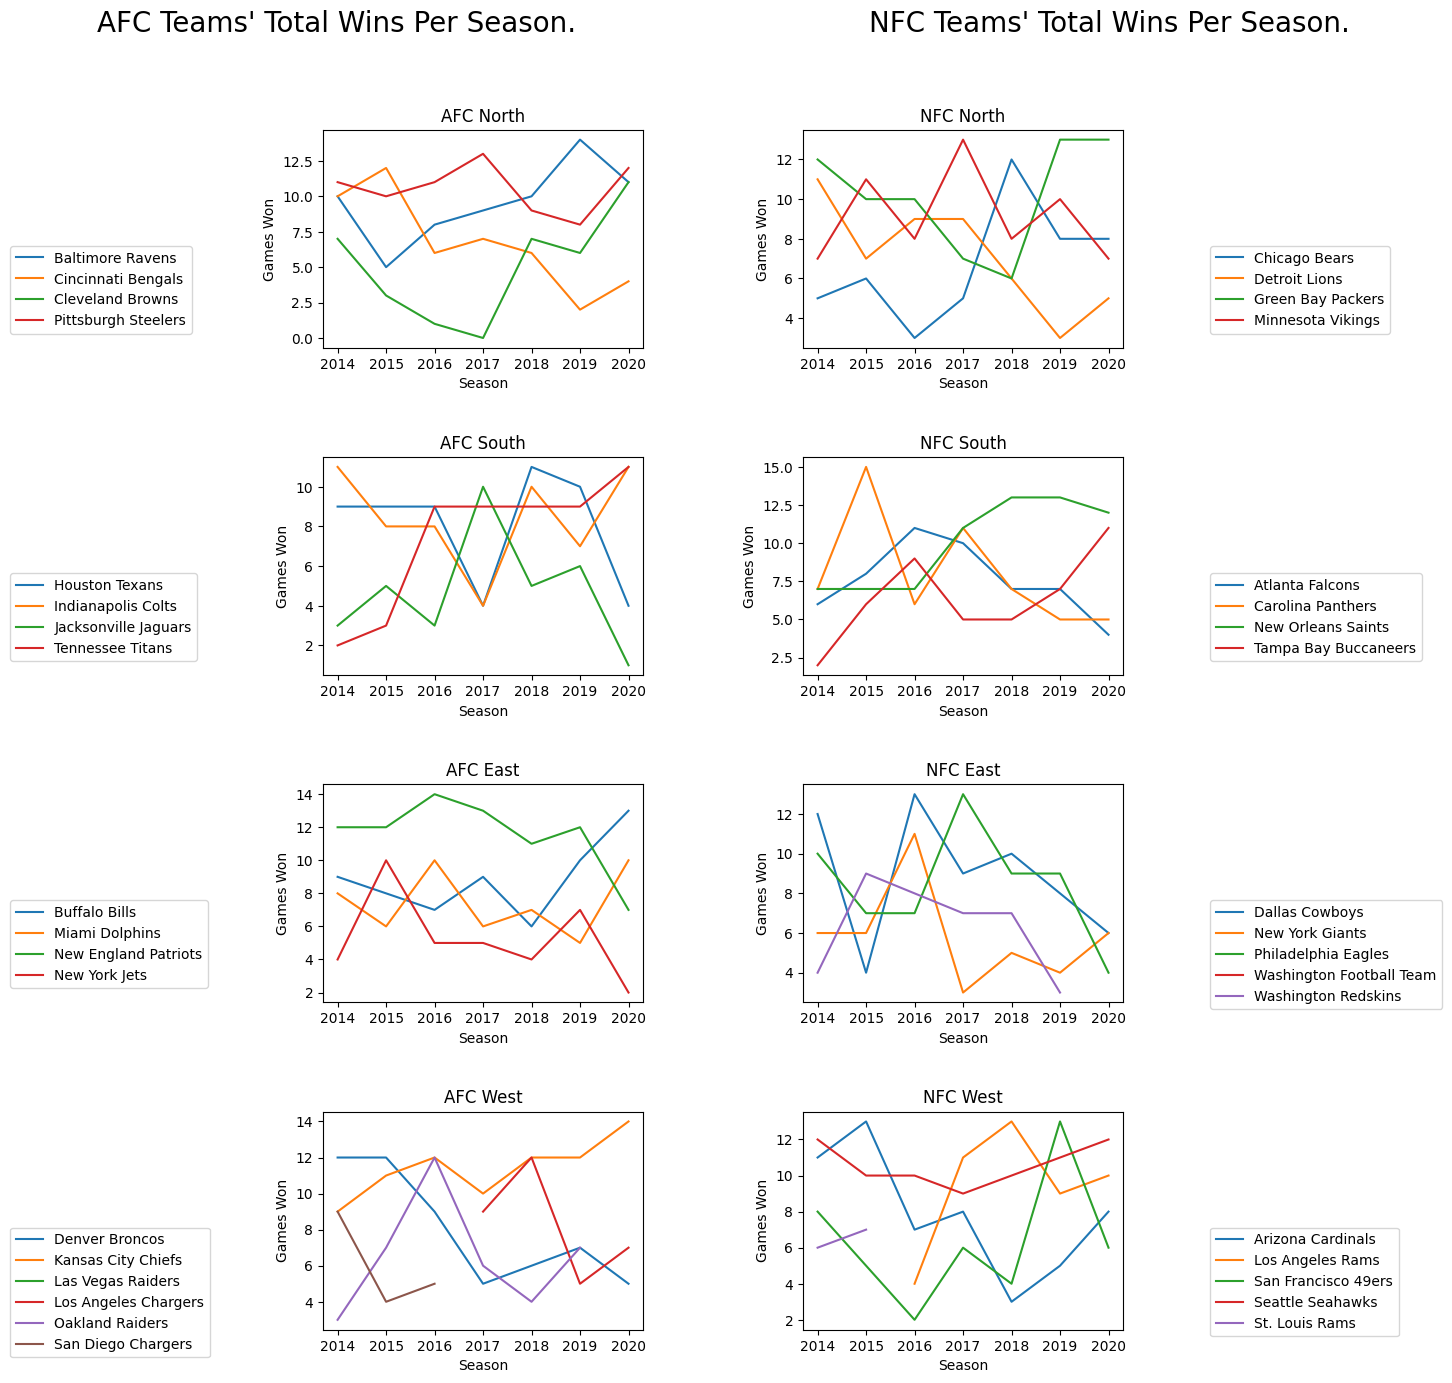

In [93]:
var = 0
fig, ax = plt.subplots(4, 2, figsize=(10,15), layout='constrained')    
fig.tight_layout(pad=5.0)
fig.subplots_adjust(left = 0.1, top = 0.9, right = 0.9, bottom = 0.1, hspace = 0.5, wspace = 0.5)
title = "AFC Teams' Total Wins Per Season.                                 NFC Teams' Total Wins Per Season." + "\n"
fig.suptitle(title, fontsize=20)
label_loc = 0

for var in range(2):
    xfc = afc
    label_loc = -1
    if (var==1):
        xfc = nfc
        label_loc = +1.25
        
    for team in range(len(full_team_list)):
    
        for league in range(len(xfc)):
            league = (league%4)
        
            if (current_teams.loc[full_team_list[team]]["team_division"] == xfc[league]) == True:
                                   
                ax[league][var].set_xlabel('Season')
                ax[league][var].set_ylabel('Games Won')

                ax[league][var].plot(season_years, seasonWinGraph[full_team_list[team]], label=full_team_list[team])
                ax[league][var].legend(loc='upper left', bbox_to_anchor=(label_loc, .5))
                
    for league in range(len(xfc)):
        
        ax[league][var].set_title(xfc[league])

    var += 1
    
plt.show(var)

This graphs will be extremely useful for the future. We plan to overlay different statistics that our model identifies as important from the position groups we have identified to show how they link to overall wins. 

In [94]:
seasonWinGraph["Washington Football Team"]
seasonWinGraph.loc[2020]["Las Vegas Raiders"]

8.0

#### Step 2

Now that we have each teams wins and losses for each season, we can define what it means to be a good, averaege, and bad team. We will do this by taking the STD, mean, and analyzing boxplots of wins per team for each season from 2014-2020. This is because our Salary Cap dataset only has data from 2014-2020.

In [95]:
seasonWins_to2020.std().mean()

3.1742396172056004

In [96]:
seasonWins_to2020.mean().mean()

7.96875

When looking at mean and STD it shows us that the average amount of wins per season is approximately 8. Let's generalize that 8 wins is the average and any team within one standard deviation is considered average. Therefore, 0-4 wins classify a team as "Bad", 5-11 wins classify a team as "Average", and 12-16 wins classify a team as "Good".

In [97]:
seasonWins_to2020.median().mean()

7.857142857142857

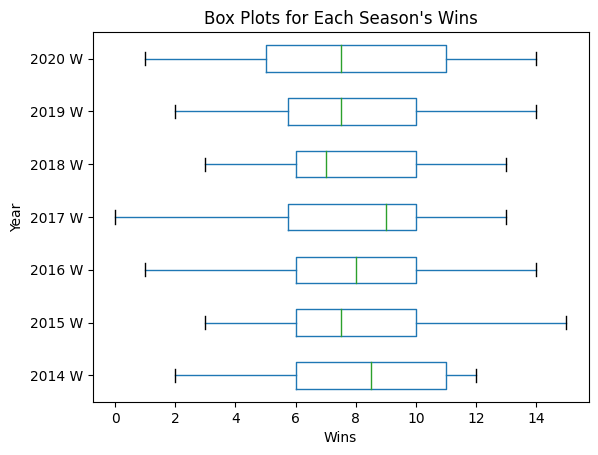

In [98]:
boxplot = seasonWins_to2020.boxplot(grid=False,vert=False)
plt.xlabel('Wins') 
plt.ylabel('Year') 
plt.title("Box Plots for Each Season's Wins")
plt.show(boxplot)

When looking at median and boxplots we see that the median (7.86) is almost exactly our mean (7.97) which indicates that the data is normally distributed. Therefore, we do not have to worry about too many outliars. This outcome further justifies our definitions for good, average, and bad. 

It is also worth mentioning that the 3rd quartile (75%) is right around 10 wins on average and the 1st quartile (25%) is right 5 wins on average. This further supports are definitions.

#### Step 3:

Now, we want to classify these teams into our stated definitions of "good", "average", and "bad". Once they are classified into these groups, we will then use the Salary Cap dataframe to identify what the top 5 positions for that team were in terms of salary cap percentage. Next, we will count the total number of positions by each group: good, average, and bad, to try to identify if there are differences in the positional valuation. 

In [99]:
num = 14
for i in range(20-13):
    x = "cap" + str(num) 
    globals()[x] = pd.DataFrame(salary_cap)
    fullYr = int(str(20) + str(num))
    globals()[x] = globals()[x][globals()[x]["season"]==fullYr]
    num += 1

In [100]:
yrNum = 14
caps = [cap14["team"], cap15["team"], cap16["team"], cap17["team"], cap18["team"], cap19["team"], cap20["team"]]
for i in range(20-13):
    bigTeam = "big_team_list" + str(yrNum)
    tmLst = "team_list" + str(yrNum)
    globals()[tmLst] = []
    
    globals()[bigTeam] = caps[i]
    globals()[bigTeam] = globals()[bigTeam].values.tolist()
    
    [globals()[tmLst].append(x) for x in globals()[bigTeam] if x not in globals()[tmLst]]
    yrNum += 1

First, for every NFL franchise, lets see how every position takes a bite out the pie:). In other words, what positions does the NFL at a whole value higher than others. This provides us with a basis going forward.

In [128]:
y = salary_cap.groupby("pos")[["cap_percent"]].sum()
ys = y["cap_percent"]
ys

pos
C       534.41
CB     1592.99
DE     1461.18
DT     1169.55
FB       95.76
FS      559.33
G       943.98
ILB     726.60
K       228.16
KR        0.02
LB       25.03
LS      102.66
LT      761.46
OLB    1296.67
P       208.47
QB     1798.51
RB      690.70
RT      463.31
S        86.07
SS      405.15
T        54.43
TE      746.33
WR     1778.80
Name: cap_percent, dtype: float64

In [120]:
mylabels = salary_cap["pos"].unique()
mylabels

array(['C', 'CB', 'DE', 'DT', 'FS', 'G', 'ILB', 'K', 'LS', 'LT', 'OLB',
       'P', 'QB', 'RB', 'RT', 'SS', 'TE', 'WR', 'S', 'T', 'FB', 'LB',
       'KR'], dtype=object)

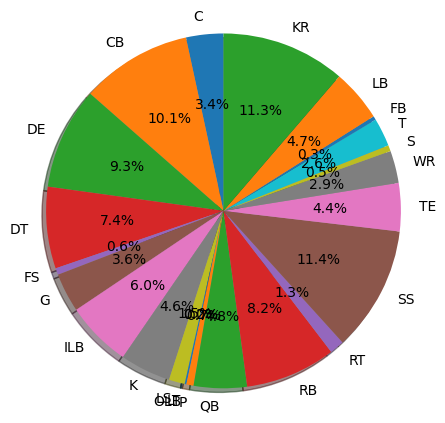

In [132]:
#pie_cap = salary_cap.drop(columns = ["Player", "cap_hit"])
#pie_cap = salary_cap.groupby("pos")[["cap_percent"]].sum()
#y = salary_cap['cap_percent']
#new = plt.pie(y, labels = mylabels)
#plt.show(new)  

plt.pie(ys, labels = mylabels, autopct='%1.1f%%', shadow=True, 
         startangle=90, radius=1.2)
plt.show() 

Throughout the years 2014-2020, there is a large portion of the teams cap_percentage going towards DE,QB,OLB,WR,CB. We will further investigate this to see if winning franchises pay different positions more frequently than losing franchises.

In [102]:
number = 2014
Win_Values = [16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 0.0]
pos_list = ["C", "CB", "DE", "DT", "FB", "FS", "G", "ILB", "K", "KR", "LB", "LS", "LT", "OLB", "P", "QB", "RB", "RT", "S", "SS", "T", "TE", "WR"] 


for i in range(20-13):
    var = "win" + str(number) 
    globals()[var] = pd.DataFrame()
    globals()[var]["Win Values"] = Win_Values
    globals()[var] = globals()[var].set_index("Win Values")
    
        
    for position in pos_list:
        globals()[var][position] = 0 
    
    number += 1

In [103]:
season_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
year = 2014
yr = 14
# stringW = str(season_yrs[year]) + " W"

for year in range(len(season_years)):
    
    lst = "team_list" + str(yr)
    
    cap = "cap" + str(yr)
    
    stringW = str(season_yrs[year]) + " W"
    
    df_name = "win" + str(season_years[year])
    
    for team in globals()[lst]:
        winScore = year_rec[stringW].loc[team]
    
        df = globals()[cap][globals()[cap]["team"]==team].sort_values(by = ["cap_percent"], ascending=False).head(5)
        df = df.reset_index()

        for position in pos_list:
            for i in range(len(df["pos"])):
                if df.loc[i]["pos"] == position:
                    globals()[df_name].loc[winScore][position] = globals()[df_name].loc[winScore][position] + 1
    
    year += 1
    yr += 1

In [104]:
for year in range(len(season_years)):
    transposed = "w" + str(season_years[year])
    og = "win" + str(season_years[year])   
    globals()[transposed] = pd.DataFrame.transpose(globals()[og])

In [105]:
#All the stats added up from seasons 2014-2020
w14to20 = pd.DataFrame()
w14to20 = w2014 + w2015 + w2016 + w2017 + w2018 + w2019 + w2020

In [106]:
good = pd.DataFrame()
average = pd.DataFrame()
bad = pd.DataFrame()

for i in range(5):
    score = i + 12.0
    iscore = i + 0.0
    bad[iscore] = w14to20[iscore]
    good[score] = w14to20[score]
    
for i in range(7):
    score = i + 5.0
    average[score] = w14to20[score]

In [107]:
pos_freq = pd.DataFrame(index=w14to20.index, columns=["Good", "Average", "Bad"])
# pos_freq(columns =["Good", "Average", "Bad"] = 0

levels = [good, average, bad]
level_str = ["Good", "Average", "Bad"]

for i in range(len(levels)):
    pos_freq[level_str[i]] = levels[i].sum(axis=1)

# pos_freq["Good"] = good.sum(axis=1)
# pos_freq["Average"] = average.sum(axis=1)
# pos_freq["Bad"] = bad.sum(axis=1)
#pos_freq.sort_values(by=["Good"], ascending=False)
#top 5 for Good: QB, LT, WR, OLB, CB
#pos_freq.sort_values(by=["Average"], ascending=False)
#top 5 for Average: QB, DE, WR, CB, OLB
#pos_freq.sort_values(by=["Bad"], ascending=False)

#top 5 for Good: QB, LT, WR, OLB, CB
#top 5 for Average: QB, DE, WR, CB, OLB
#top 5 for Bad: WR, CB, QB, DE, OLB
# pos_freq.sum(axis=1).sort_values(ascending=False)
#pos_freq.sum(axis=1).sort_values(ascending=False)

In [108]:
pos_freq.sum(axis=1).sum()

1120

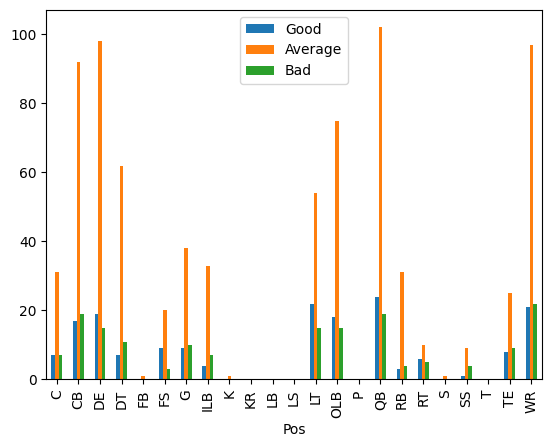

In [109]:
pos_freq.index.name = "Pos"
plt.show(pos_freq.plot.bar())

Here we are trying to analyze if there is a difference in what positions, good, average, and bad teams play. This graph is showing the frequency that a position was in the top 5 for their respective team in terms of market cap percentage. From this graph, we see that there are a core group of positions that are valued higher than others. These positions are as follows: CB,DE,WR,LT,QB,OLB. Based on these findings, we will only analyze these positions statistics because it is apparent that NFL teams value them higher than others. 

We have stats for each position group and their market cap %. Lets connect the two and create a new dataframe.

In [110]:
test = pd.DataFrame()
test = salary_cap[salary_cap["season"]==2020]
test = test[test["team"]=="New York Giants"]
test.sort_values(by="cap_percent", ascending=False).head()
test = def2020.merge(test, on=["Player"])
test

,Player,Age,Team,Pos,Played,Started,Int,Pass Def,FF,FR,...,Comb,Solo,Ast,TFL,QBHits,pos,cap_hit,cap_percent,season,team
0,Jabaal Sheard,31,NaN,DE,10,3,0,1,1,0,...,19,10,9,2,6,DE,485298,0.25,2020,New York Giants
1,Madre Harper,23,New York Giants,CB,9,0,0,0,0,1,...,5,5,0,0,0,CB,502352,0.25,2020,New York Giants
2,Niko Lalos,23,New York Giants,DE,6,0,1,1,0,1,...,6,2,4,0,0,DE,143529,0.07,2020,New York Giants


# Think We delete This graph below

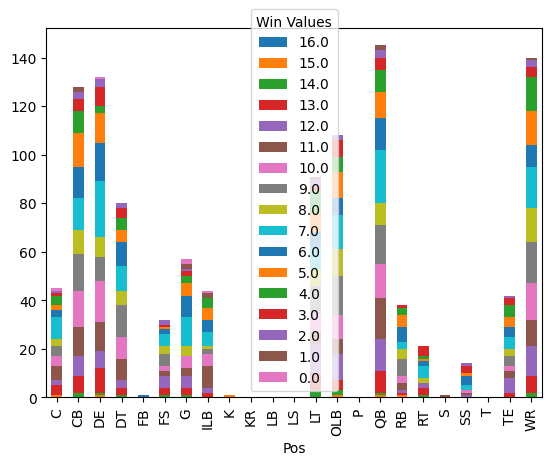

In [111]:
#w14to20.plot.bar(stacked=True)
plt.show(w14to20.plot.bar(stacked=True))

# Our Model

Insert the two types of models we are thinking about using and why

# Closing Thoughts and Final Goals

Our main goal is to predict an NFL Franchise's total wins for a given season based on the essential positions we have idenfited: CB,WR,QB,DE,OLB. We will do this by creating a predictive model that analyzes the statistics for each position group. For example, it will know what a 14 win QB looks like based on the stastics for previous years, therefore if we plug in statistics for these position groups, we should be able to predict what an NFL Teams record will be. Questions we want to answer are: "If an NFL franchise does not have one of these position groups in their top 5 % of market_cap, how do they perform" "How do teams perform without a QB in the top of their market cap?" "What statistics matter the most for each position?". Ultimately, we want to be able to predict a teams wins based on what these 5 positions have historically done. 